## Logistic regression

In [162]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [163]:
file_path = 'C:\\Users\\Admin\\Downloads\\RESEARCH\\THESIS.xlsx'
data = pd.read_excel(file_path, header=1)

In [164]:
data

,Serial number,Patient Initials,Gender,Age (years),Comorbidities,Family history of hypertension,History of hypertensive crisis,Weight (Kg),Height (metre),Height (in cm),...,SBP3,Mean SBP (not rounded),Mean SBP (Rounded to two digits),According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive),DBP1,DBP2,DBP3,Mean DBP (not rounded),Mean DBP (Rounded),According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive).1
0,1.0,AC,M,6.0,N,Y,N,28.0,1.15,115.0,...,112.0,112.000000,112.0,H,76.0,76.0,75.0,75.500000,75.5,H
1,26.0,MA,M,6.0,N,N,N,20.0,1.24,124.0,...,86.0,88.000000,88.0,N,64.0,68.0,64.0,66.000000,66.0,N
2,62.0,AN,M,6.0,N,N,N,27.0,1.13,113.0,...,108.0,106.000000,106.0,N,64.0,64.0,68.0,66.000000,66.0,N
3,82.0,HNN,M,6.0,N,N,N,27.0,1.13,113.0,...,88.0,88.000000,88.0,N,68.0,68.0,68.0,68.000000,68.0,N
4,102.0,TRE,M,6.0,N,N,N,27.0,1.13,113.0,...,88.0,90.000000,90.0,N,66.0,64.0,64.0,64.000000,64.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,98.095052,NaN,NaN,NaN,NaN,NaN,66.402344,NaN,NaN


In [165]:
columns_to_drop = ['Patient Initials','Comorbidities', 
                   'History of hypertensive crisis', 'Height (in cm)','Unnamed: 11', 'Unnamed: 12', 'round WHtR', 'round waist-hip ratio',
                   'SBP1', 'SBP2', 'SBP3', 'DBP1', 'DBP2', 'DBP3']
data = data.drop(columns=columns_to_drop)

In [166]:
data.columns

Index(['Serial number', 'Gender', 'Age (years)',
       'Family history of hypertension', 'Weight (Kg)', 'Height (metre)',
       'BMI (kg/m2)', 'Hip circumference (cm)', 'Waist circumference (cm)',
       'Waist-height ratio', 'Waist-hip ratio', 'Mean SBP (not rounded)',
       'Mean SBP (Rounded to two digits)',
       'According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive)',
       'Mean DBP (not rounded)', 'Mean DBP (Rounded)',
       'According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive).1'],
      dtype='object')

In [167]:
# Select features
features = ['Age (years)', 'Weight (Kg)', 'Height (metre)', 'BMI (kg/m2)',
            'Hip circumference (cm)', 'Waist circumference (cm)',
            'Waist-height ratio', 'Waist-hip ratio', 'Mean SBP (not rounded)',
            'Mean DBP (not rounded)', 'Gender', 'Family history of hypertension']

In [168]:

data['Hypertensive'] = ((data['According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive)'] == 'H') | 
                       ((data['According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive).1'] == 'H')).astype(int))

In [169]:
# Drop the original classification columns
data = data.drop(columns=['According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive)', 
                          'According to Fourth report; N=Normal; PH=prehypertensive; H=Hypertensive).1'])

In [170]:
data['Hypertensive'].value_counts()

Hypertensive
False    379
True      12
Name: count, dtype: int64

In [171]:
X = data[features]
y = data['Hypertensive']

In [172]:
y

0       True
1      False
2      False
3      False
4      False
       ...  
386    False
387    False
388    False
389    False
390    False
Name: Hypertensive, Length: 391, dtype: bool

In [173]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [174]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_features)

In [175]:
##### Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [176]:
# Create a preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=42))])

In [177]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False to handle sparse matrix from OneHotEncoder
])

In [178]:
#Prepare the data
X_prepared = pipeline.fit_transform(X)

In [179]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

In [180]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [181]:
# Check class distribution
print(y_train_resampled.value_counts())


Hypertensive
False    303
True     303
Name: count, dtype: int64


In [182]:
# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [183]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]


In [184]:
# Print results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[68  8]
 [ 0  3]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.89      0.94        76
        True       0.27      1.00      0.43         3

    accuracy                           0.90        79
   macro avg       0.64      0.95      0.69        79
weighted avg       0.97      0.90      0.92        79



In [185]:
# Get feature names after preprocessing
feature_names = (numeric_features.tolist() + 
                 pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())


In [186]:
# Get feature importances
importances = model.coef_[0]
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': abs(importances)})
feature_importance = feature_importance.sort_values('importance', ascending=False)

In [187]:
print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


Top 10 Feature Importances:
                               feature  importance
8               Mean SBP (not rounded)    3.178404
1                          Weight (Kg)    2.435762
0                          Age (years)    2.393267
5             Waist circumference (cm)    1.588334
9               Mean DBP (not rounded)    1.321919
2                       Height (metre)    1.259110
7                      Waist-hip ratio    1.122741
3                          BMI (kg/m2)    1.035827
12                          Gender_nan    0.880164
15  Family history of hypertension_nan    0.880164


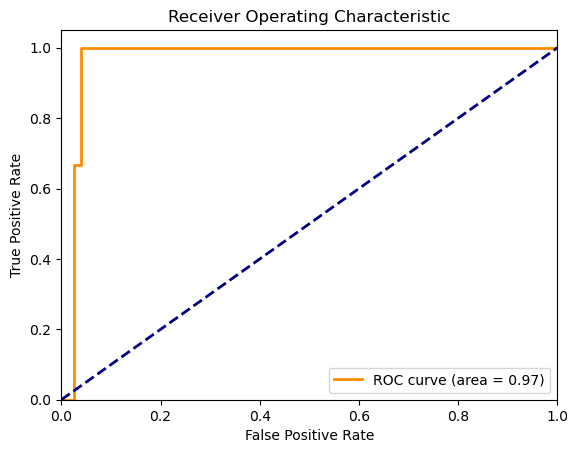

In [188]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [89]:
# Predictions on the balanced training set
y_train_pred = model.predict(X_train_resampled)

# Confusion Matrix and Classification Report for the training data
print("Confusion Matrix (Training Data):")
print(confusion_matrix(y_train_resampled, y_train_pred))

print("\nClassification Report (Training Data):")
print(classification_report(y_train_resampled, y_train_pred))


Confusion Matrix (Training Data):
[[296   7]
 [  0 303]]

Classification Report (Training Data):
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       303
        True       0.98      1.00      0.99       303

    accuracy                           0.99       606
   macro avg       0.99      0.99      0.99       606
weighted avg       0.99      0.99      0.99       606



In [93]:
# Adjust threshold
threshold = 0.6  # Modify this value

# Predict based on the threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Confusion Matrix and Classification Report with adjusted threshold
print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

print("\nClassification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))


Confusion Matrix with Adjusted Threshold:
[[69  7]
 [ 0  3]]

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

       False       1.00      0.91      0.95        76
        True       0.30      1.00      0.46         3

    accuracy                           0.91        79
   macro avg       0.65      0.95      0.71        79
weighted avg       0.97      0.91      0.93        79



## Random forest

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Create a new Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model directly (without the pipeline)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))

# Feature importance for Random Forest
feature_names = (numeric_features.tolist() + 
                 preprocessor.named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({ 'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances (Random Forest):")
print(feature_importance.head(10))

Random Forest Results:

Confusion Matrix:
[[72  4]
 [ 1  2]]

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.97        76
        True       0.33      0.67      0.44         3

    accuracy                           0.94        79
   macro avg       0.66      0.81      0.71        79
weighted avg       0.96      0.94      0.95        79


Top 10 Feature Importances (Random Forest):
                             feature  importance
9             Mean DBP (not rounded)    0.307203
8             Mean SBP (not rounded)    0.289168
14  Family history of hypertension_Y    0.094030
13  Family history of hypertension_N    0.084616
7                    Waist-hip ratio    0.041100
3                        BMI (kg/m2)    0.037961
1                        Weight (Kg)    0.033734
2                     Height (metre)    0.026866
0                        Age (years)    0.022337
5           Waist circumference (cm)    0.018171


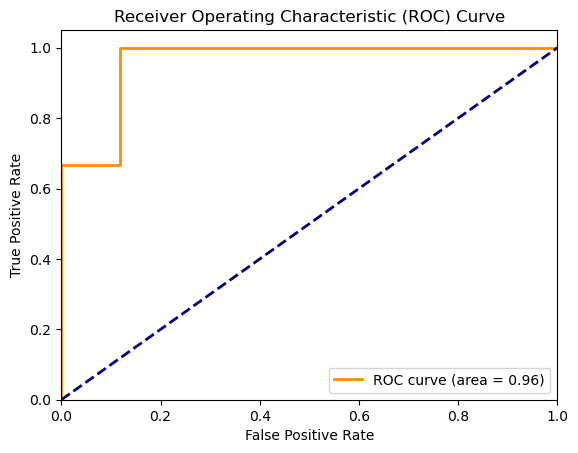

In [191]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict the probabilities for the positive class (hypertensive)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_probabilities)
roc_auc = roc_auc_score(y_test, rf_probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## SVM

In [192]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [193]:
# Create an SVM model with probability estimates enabled
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Fit the SVM model
svm_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
svm_predictions = svm_model.predict(X_test)

In [194]:
# Evaluate the model
print("SVM Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))
print("\nClassification Report:")
print(classification_report(y_test, svm_predictions))


SVM Results:

Confusion Matrix:
[[73  3]
 [ 0  3]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.96      0.98        76
        True       0.50      1.00      0.67         3

    accuracy                           0.96        79
   macro avg       0.75      0.98      0.82        79
weighted avg       0.98      0.96      0.97        79



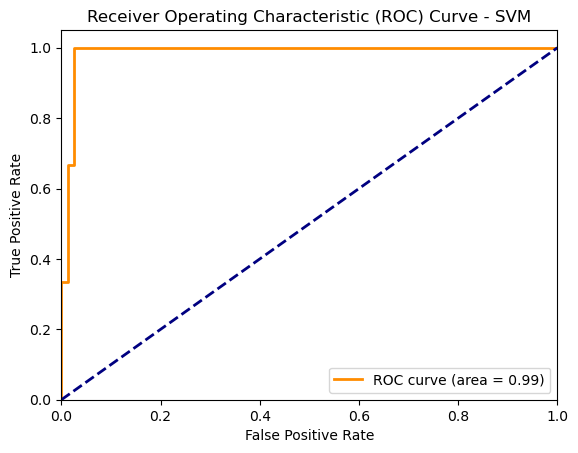

In [195]:
# Predict the probabilities for the positive class (hypertensive)
svm_probabilities = svm_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, svm_probabilities)
roc_auc = roc_auc_score(y_test, svm_probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.show()


## GRADIENT BOOSTING

In [196]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [197]:
# Create a Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Fit the Gradient Boosting model
gb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
gb_predictions = gb_model.predict(X_test)

In [198]:
# Evaluate the model
print("Gradient Boosting Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, gb_predictions))
print("\nClassification Report:")
print(classification_report(y_test, gb_predictions))

Gradient Boosting Results:

Confusion Matrix:
[[75  1]
 [ 1  2]]

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99        76
        True       0.67      0.67      0.67         3

    accuracy                           0.97        79
   macro avg       0.83      0.83      0.83        79
weighted avg       0.97      0.97      0.97        79



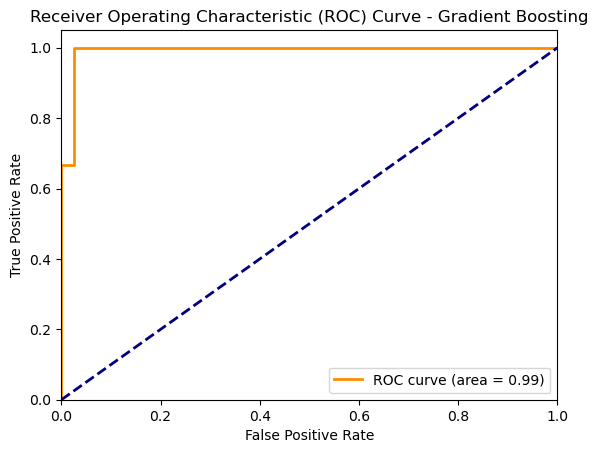

In [199]:
# Predict the probabilities for the positive class (hypertensive)
gb_probabilities = gb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, gb_probabilities)
roc_auc = roc_auc_score(y_test, gb_probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


## XGB CLASSIFIER

In [200]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [201]:
# Create an XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the XGBoost model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:18:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [202]:
# Evaluate the model
print("XGBoost Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, xgb_predictions))
print("\nClassification Report:")
print(classification_report(y_test, xgb_predictions))


XGBoost Results:

Confusion Matrix:
[[75  1]
 [ 0  3]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      0.99        76
        True       0.75      1.00      0.86         3

    accuracy                           0.99        79
   macro avg       0.88      0.99      0.93        79
weighted avg       0.99      0.99      0.99        79



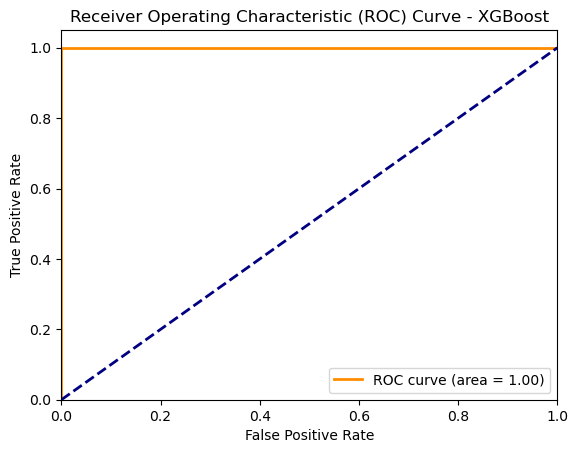

In [203]:
# Predict the probabilities for the positive class (hypertensive)
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, xgb_probabilities)
roc_auc = roc_auc_score(y_test, xgb_probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()
